# Run inference on a Sentinel-2 image from the Google Earth Engine

* **Last Modified**: 30-08-2024
* **Author**: Gonzalo Mateo-García
---
<h1> <img src="https://raw.githubusercontent.com/IPL-UV/cloudsen12_models/refs/heads/main/notebooks/logo.webp" alt="Logo" width='5%'> <a href="https://cloudsen12.github.io/"> CloudSEN12 </a></h1>

This notebook shows how to run the CloudSEN12 model over an image downloaded from the Google Earth Engine. Hence to run this notebook you a Google Earth Engine account. 

We will run the models **UnetMobV2_V1** and **UnetMobV2_V2** with all bands proposed in:


Aybar, C., Ysuhuaylas, L., Loja, J., Gonzales, K., Herrera, F., Bautista, L., Yali, R., Flores, A., Diaz, L., Cuenca, N., Espinoza, W., Prudencio, F., Llactayo, V., Montero, D., Sudmanns, M., Tiede, D., Mateo-García, G., & Gómez-Chova, L. (2022). **CloudSEN12, a global dataset for semantic understanding of cloud and cloud shadow in Sentinel-2**. *Scientific Data, 9(1), Article 1*. DOI: [10.1038/s41597-022-01878-2](https://doi.org/10.1038/s41597-022-01878-2)


Aybar, C., Bautista, L., Montero, D., Contreras, J., Ayala, D., Prudencio, F., Loja, J., Ysuhuaylas, L., Herrera, F., Gonzales, K., Valladares, J., Flores, L. A., Mamani, E., Quiñonez, M., Fajardo, R., Espinoza, W., Limas, A., Yali, R., Alcántara, A., Leyva, M., Loayza-Muro, M., Willems, M., Mateo-García, G. & Gómez-Chova, L. (2024). **CloudSEN12+: The largest dataset of expert-labeled pixels for cloud and cloud shadow detection in Sentinel-2**. *Data in Brief, 110852*. DOI: [10.1016/j.dib.2024.110852](https://doi.org/10.1016/j.dib.2024.110852)

In [1]:
from cloudsen12_models import cloudsen12
import ee
import matplotlib.pyplot as plt
from georeader import plot
from shapely.geometry import box
from georeader.readers import ee_image

In [ ]:
ee.Authenticate()
ee.Initialize()

In [3]:
collection_name = "COPERNICUS/S2_HARMONIZED"
tile = "S2A_MSIL1C_20240417T064631_N0510_R020_T40RCN_20240417T091941"
img_col = ee.ImageCollection(collection_name)
image = img_col.filter(ee.Filter.eq("PRODUCT_ID", tile)).first()
info_img = image.getInfo()
# info_img

In [4]:
%%time

from rasterio import Affine
# projgee = image.select("B2").projection().getInfo()

aoi = box(55.325, 25.225, 55.415, 25.28)

bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
crs = info_img["bands"][1]["crs"]
transform = Affine(*info_img["bands"][1]["crs_transform"])
img_local = ee_image.export_image(info_img['id'],
                                  crs=crs, transform=transform,
                                  bands_gee=bands,
                                  geometry=aoi)
img_local

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


CPU times: user 421 ms, sys: 86.6 ms, total: 508 ms
Wall time: 4.18 s


 
         Transform: | 10.00, 0.00, 331260.00|
| 0.00,-10.00, 2797010.00|
| 0.00, 0.00, 1.00|
         Shape: (13, 622, 916)
         Resolution: (10.0, 10.0)
         Bounds: (331260.0, 2790790.0, 340420.0, 2797010.0)
         CRS: EPSG:32640
         fill_value_default: 0.0
        

<Axes: >

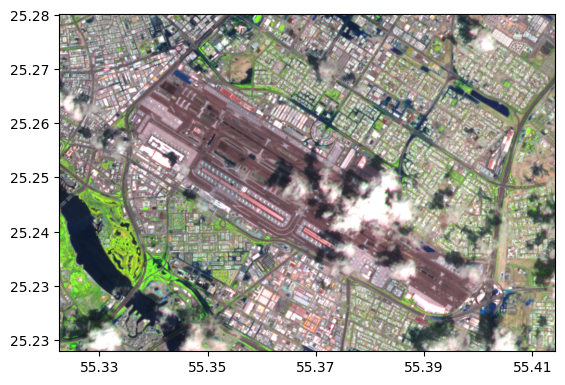

In [5]:
swirnirred = (img_local.isel({"band": [bands.index(b) for b in ["B11","B8","B4"]]}) / 4_500.).clip(0,1)

plot.show(swirnirred)

### UNetMobV2_V1

Model trained on the first version of CloudSEN12 [Aybar et al. 2022](https://doi.org/10.1038/s41597-022-01878-2).

In [6]:
model = cloudsen12.load_model_by_name(name="UNetMobV2_V1", weights_folder="cloudsen12_models")

/home/gonzalo/git/cloudsen12_models/cloudsen12_models/cloudsen12.py:189: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weights_file, map_location=device

In [7]:
cloudsen12.MODELS_CLOUDSEN12.keys()

dict_keys(['cloudsen12', 'UNetMobV2_V1', 'UNetMobV2_V2', 'cloudsen12l2a', 'dtacs4bands', 'landsat30'])

In [8]:
cloudmask = model.predict(img_local/10_000)

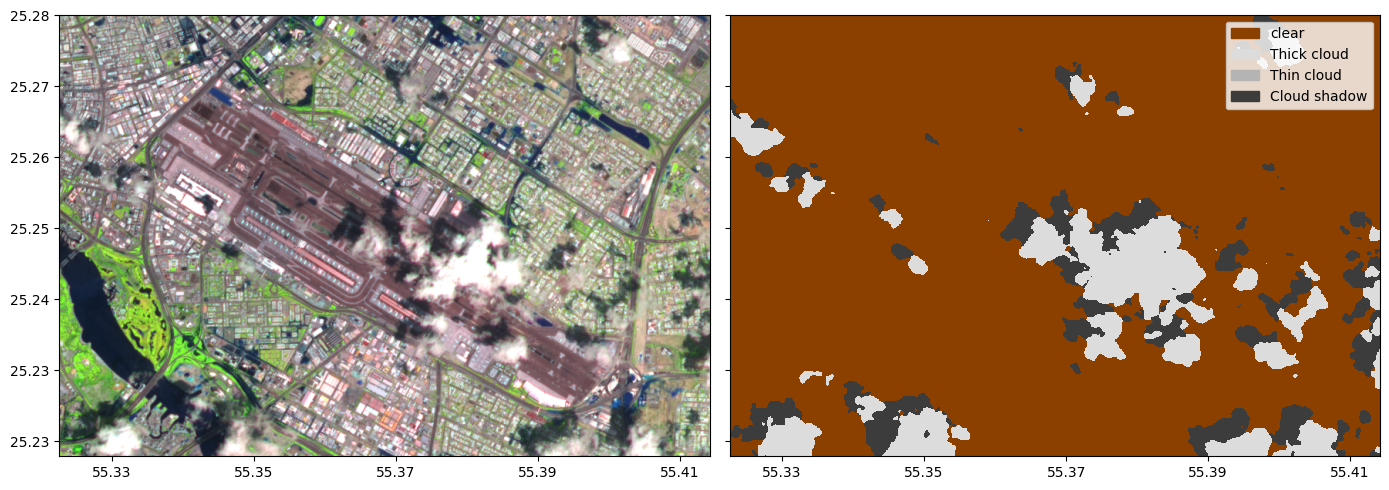

In [9]:
fig, ax = plt.subplots(1,2,figsize=(14,5),sharey=True, tight_layout=True)

plot.show(swirnirred,ax=ax[0])
cloudsen12.plot_cloudSEN12mask(cloudmask,ax=ax[1])
fig.savefig("example_flood_dubai_2024.png")

## UnetMobV2_V2

Model trained on the second version of CloudSEN12 (called CloudSEN12+) [Aybar et al. 2024](https://doi.org/10.1016/j.dib.2024.110852).

<Axes: >

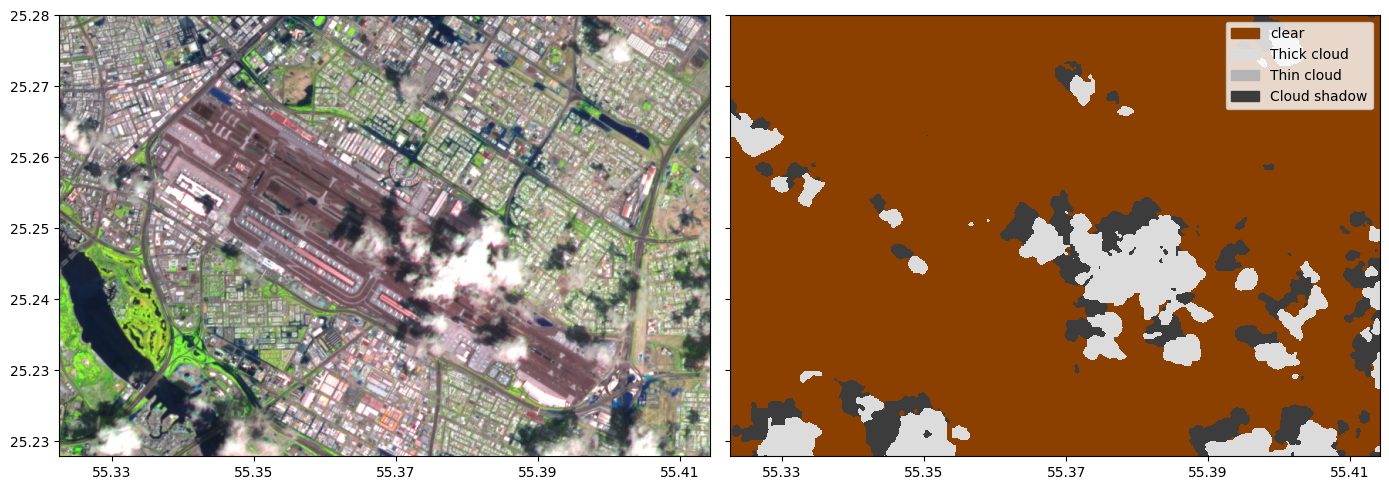

In [10]:
modelv2 = cloudsen12.load_model_by_name(name="UNetMobV2_V2", weights_folder="cloudsen12_models")
cloudmaskv2 = modelv2.predict(img_local/10_000)
fig, ax = plt.subplots(1,2,figsize=(14,5),sharey=True, tight_layout=True)

plot.show(swirnirred,ax=ax[0])
cloudsen12.plot_cloudSEN12mask(cloudmaskv2,ax=ax[1])


## Sentinel-2 L2A

Run the model for L2A images.

In [11]:
from shapely.geometry import mapping
collection_name = "COPERNICUS/S2_SR_HARMONIZED"
tile = "S2A_MSIL2A_20240417T064631_N0510_R020_T40RCN_20240417T091941"
aoi_ee = ee.Geometry(mapping(aoi))
img_col = ee.ImageCollection(collection_name).filterDate('2024-04-17', '2024-04-18').filterBounds(aoi_ee)
image = img_col.first()
info_imgl2a = image.getInfo()
# info_imgl2a

In [12]:
bandsl2a = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
crs = info_imgl2a["bands"][1]["crs"]
transform = Affine(*info_imgl2a["bands"][1]["crs_transform"])
img_local_l2a = ee_image.export_image(info_imgl2a['id'],
                                  crs=crs, transform=transform,
                                  bands_gee=bandsl2a,
                                  geometry=aoi)
img_local_l2a

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


 
         Transform: | 10.00, 0.00, 331260.00|
| 0.00,-10.00, 2797010.00|
| 0.00, 0.00, 1.00|
         Shape: (12, 622, 916)
         Resolution: (10.0, 10.0)
         Bounds: (331260.0, 2790790.0, 340420.0, 2797010.0)
         CRS: EPSG:32640
         fill_value_default: 0.0
        

<Axes: >

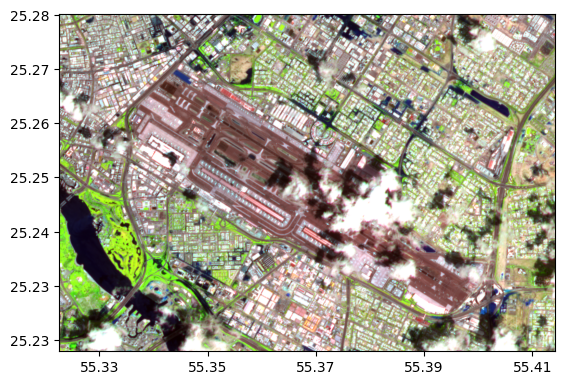

In [13]:
swirnirred_l2a = (img_local_l2a.isel({"band": [bandsl2a.index(b) for b in ["B11","B8","B4"]]}) / 4_500.).clip(0,1)

plot.show(swirnirred_l2a)

<Axes: >

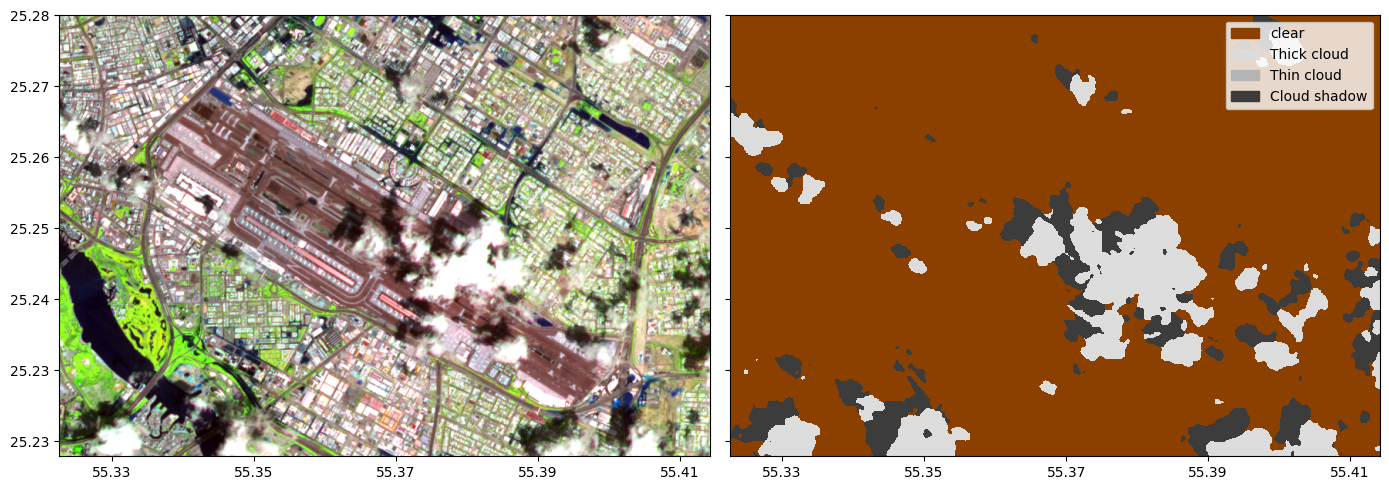

In [14]:
modell2a = cloudsen12.load_model_by_name(name="cloudsen12l2a", weights_folder="cloudsen12_models")
cloudmask_l2a = modell2a.predict(img_local_l2a/10_000)
fig, ax = plt.subplots(1,2,figsize=(14,5),sharey=True, tight_layout=True)

plot.show(swirnirred_l2a,ax=ax[0])
cloudsen12.plot_cloudSEN12mask(cloudmask_l2a,ax=ax[1])

## Licence
The `cloudsen12_models` package is published under a [GNU Lesser GPL v3 licence](https://www.gnu.org/licenses/lgpl-3.0.en.html)

The *CloudSEN12* database and all pre-trained models are released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt). For using the models in comercial pipelines written consent by the authors must be provided.

This notebook is released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt).

 If you find this work useful please cite:
```
@article{aybar_cloudsen12_2024,
	title = {{CloudSEN12}+: {The} largest dataset of expert-labeled pixels for cloud and cloud shadow detection in {Sentinel}-2},
	issn = {2352-3409},
	url = {https://www.sciencedirect.com/science/article/pii/S2352340924008163},
	doi = {10.1016/j.dib.2024.110852},
	journal = {Data in Brief},
	author = {Aybar, Cesar and Bautista, Lesly and Montero, David and Contreras, Julio and Ayala, Daryl and Prudencio, Fernando and Loja, Jhomira and Ysuhuaylas, Luis and Herrera, Fernando and Gonzales, Karen and Valladares, Jeanett and Flores, Lucy A. and Mamani, Evelin and Quiñonez, Maria and Fajardo, Rai and Espinoza, Wendy and Limas, Antonio and Yali, Roy and Alcántara, Alejandro and Leyva, Martin and Loayza-Muro, Rau´l and Willems, Bram and Mateo-García, Gonzalo and Gómez-Chova, Luis},
	month = aug,
	year = {2024},
	pages = {110852},
}

@article{aybar_cloudsen12_2022,
	title = {{CloudSEN12}, a global dataset for semantic understanding of cloud and cloud shadow in {Sentinel}-2},
	volume = {9},
	issn = {2052-4463},
	url = {https://www.nature.com/articles/s41597-022-01878-2},
	doi = {10.1038/s41597-022-01878-2},
	number = {1},
	urldate = {2023-01-02},
	journal = {Scientific Data},
	author = {Aybar, Cesar and Ysuhuaylas, Luis and Loja, Jhomira and Gonzales, Karen and Herrera, Fernando and Bautista, Lesly and Yali, Roy and Flores, Angie and Diaz, Lissette and Cuenca, Nicole and Espinoza, Wendy and Prudencio, Fernando and Llactayo, Valeria and Montero, David and Sudmanns, Martin and Tiede, Dirk and Mateo-García, Gonzalo and Gómez-Chova, Luis},
	month = dec,
	year = {2022},
	pages = {782},
}
```